In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import os, sys
import h5py
from trajectory_creator import Cart2D_traj_gen, prop2D_traj_gen, ACS_Cart2D_traj_gen
from motion_ops import motion_adjoint, motion_forward, motion_normal

os.environ["TOOLBOX_PATH"] = "/home/blevac/misc/HW/bart-0.6.00"  ## change to YOUR path
sys.path.append("/home/blevac/misc/HW/bart-0.6.00/python")        ## change to YOUR path
os.environ["OMP_NUM_THREADS"] = "1"
from bart import bart

from CG_motion import conjgrad_motion_nufft

/home/blevac/anaconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load kspace and coil maps

In [2]:
device = 'cuda'
ksp_folder = sorted(glob.glob('/csiNAS/mridata/fastmri_brain/multicoil_val/*T2*.h5')) # change to YOUR path
print()
sample_num = 1
ksp_file = ksp_folder[sample_num]
print(ksp_file)

slic = 2
with h5py.File(ksp_file,'r') as cont:
    # print(cont.keys())
    ksp = np.asarray(cont['kspace'][slic])



/csiNAS/mridata/fastmri_brain/multicoil_val/file_brain_AXT2_200_2000021.h5


## Reformat synthetic data to (384x384)

In [3]:
def _expand_shapes(*shapes):

    shapes = [list(shape) for shape in shapes]
    max_ndim = max(len(shape) for shape in shapes)
    shapes_exp = [[1] * (max_ndim - len(shape)) + shape
                  for shape in shapes]

    return tuple(shapes_exp)
    
def resize(input, oshape, ishift=None, oshift=None):
    """Resize with zero-padding or cropping.

    Args:
        input (array): Input array.
        oshape (tuple of ints): Output shape.
        ishift (None or tuple of ints): Input shift.
        oshift (None or tuple of ints): Output shift.

    Returns:
        array: Zero-padded or cropped result.
    """

    ishape1, oshape1 = _expand_shapes(input.shape, oshape)

    if ishape1 == oshape1:
        return input.reshape(oshape)

    if ishift is None:
        ishift = [max(i // 2 - o // 2, 0) for i, o in zip(ishape1, oshape1)]

    if oshift is None:
        oshift = [max(o // 2 - i // 2, 0) for i, o in zip(ishape1, oshape1)]

    copy_shape = [min(i - si, o - so)
                  for i, si, o, so in zip(ishape1, ishift, oshape1, oshift)]
    islice = tuple([slice(si, si + c) for si, c in zip(ishift, copy_shape)])
    oslice = tuple([slice(so, so + c) for so, c in zip(oshift, copy_shape)])

    output = np.zeros(oshape1, dtype=input.dtype)
    input = input.reshape(ishape1)
    output[oslice] = input[islice]

    return output.reshape(oshape)

# write function to take centered fft of image
def fftc(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img),norm='ortho'))
# write function to take centered ifft of image
def ifftc(img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(img),norm='ortho'))

In [4]:
H = 384
W = 384
np_gt_coil_imgs = resize(ifftc(ksp), (ksp.shape[0],H,W))[None,...]
np_gt_coil_ksp  = fftc(np_gt_coil_imgs)
gt_coil_imgs    = torch.tensor(np_gt_coil_imgs)
print(gt_coil_imgs.shape)

torch.Size([1, 16, 384, 384])


## Calculate coil maps

Done.


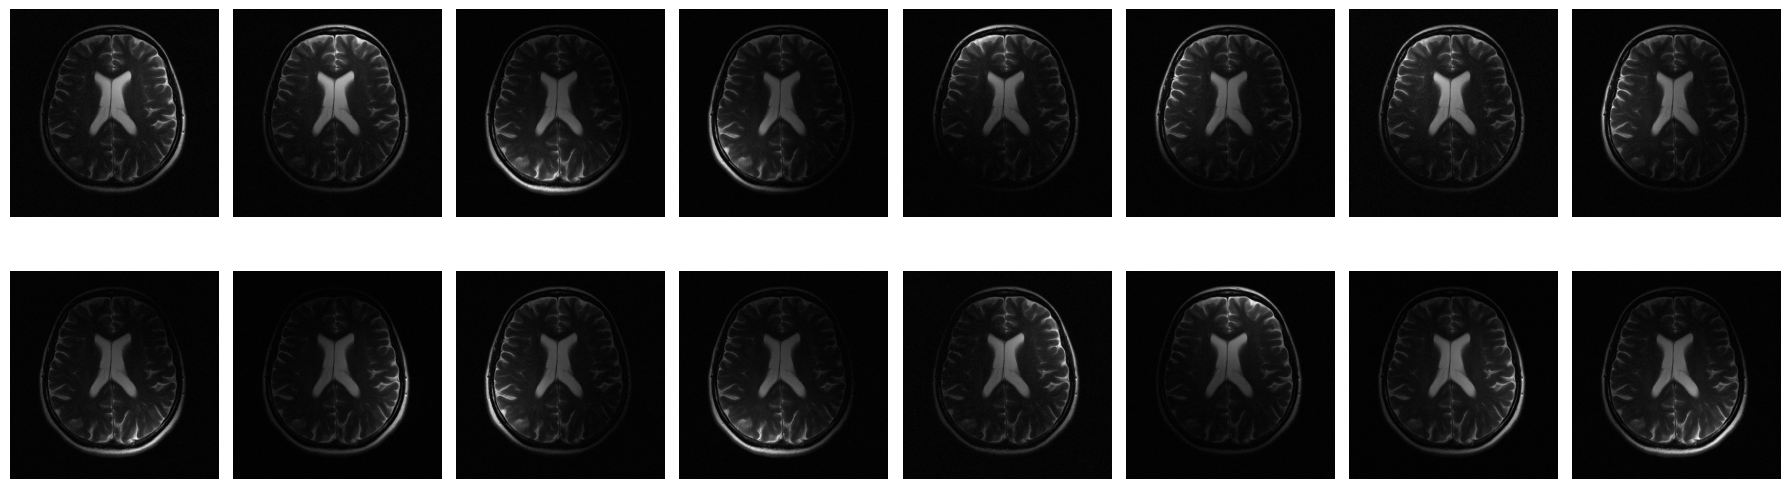

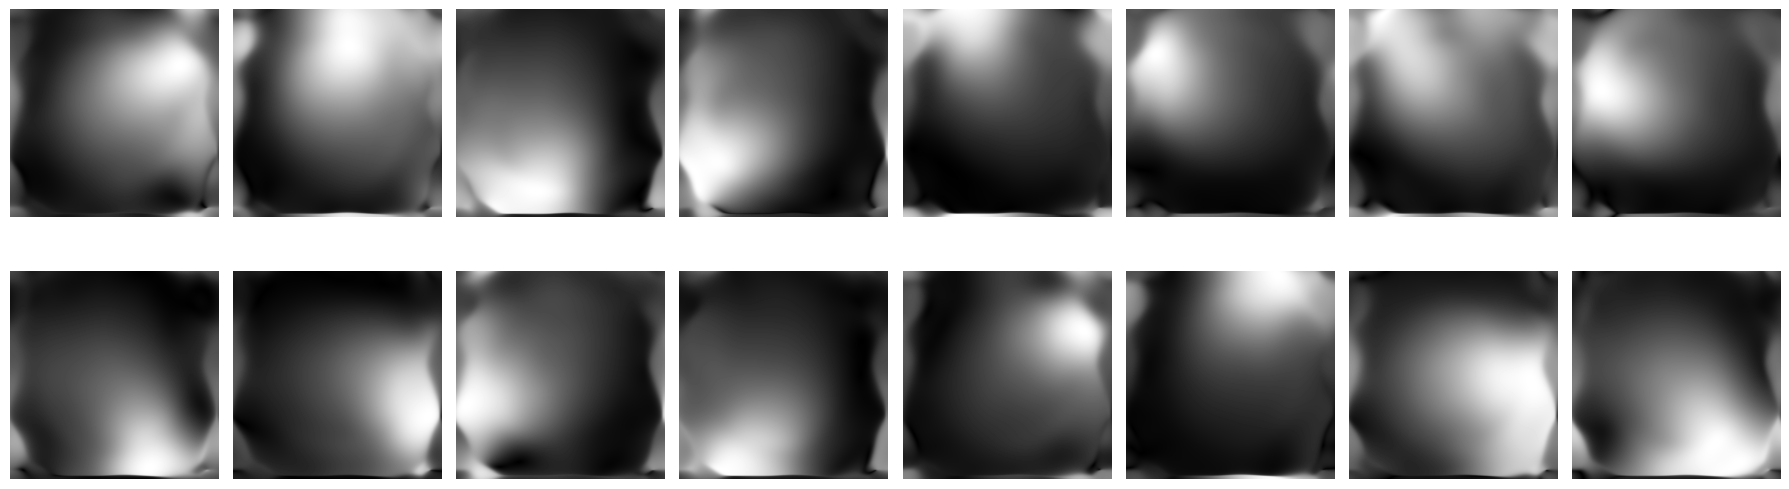

In [5]:
#generate new maps off of cropped ksp
np_gt_coil_ksp = np.transpose(np_gt_coil_ksp,(-2,-1,0,1))
sens = bart(1, 'ecalib -m1 -W -c0', np_gt_coil_ksp) #requires data of the form (Row,Column,None,Coil)<-output of ecalib too, this should then be saved (slice, coil, rows, columns)
new_maps = torch.tensor(sens).permute(-2,-1,0,1)


plt.figure(figsize=(18,6))
for i in range(gt_coil_imgs.shape[1]):
    plt.subplot(2,8,i+1)
    plt.imshow(torch.flipud(abs(gt_coil_imgs[0,i])),cmap='gray')
    plt.axis('off')

plt.tight_layout()


plt.figure(figsize=(18,6))
for i in range(gt_coil_imgs.shape[1]):
    plt.subplot(2,8,i+1)
    plt.imshow(torch.flipud(abs(new_maps[0,i])),cmap='gray')
    plt.axis('off')

plt.tight_layout()


torch.Size([1, 16, 384, 384])
torch.Size([1, 16, 384, 384])
torch.Size([1, 1, 384, 384])


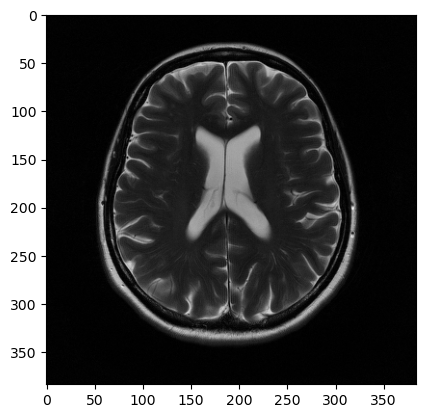

In [6]:
print(new_maps.shape)
print(gt_coil_imgs.shape)
gt_img = torch.sum(torch.conj(new_maps.cpu())*gt_coil_imgs.cpu(), axis=1)[:,None,...]
print(gt_img.shape)
plt.figure()
plt.imshow(np.flipud(abs(gt_img[0,0])),cmap='gray')

## Create motion states and aquisition trajectory

In [7]:
#Generate GT image
R = 4
TRs = 24
ETL = 16
max = 2.0
N_RO = 384
coords = Cart2D_traj_gen(TRs=TRs, ETL=ETL, N_RO=384, ro_dir='x', ordering='interleave')
ktraj = torch.tensor(coords[0::R]).to(device)
# traj = ACS_Cart2D_traj_gen(TRs=TRs, ETL=ETL, N_RO=N_RO, R=R, ro_dir = 'y', ordering='ACS_random', acs_perc=0.06)
# print(traj.shape)
# ktraj=torch.tensor(np.concatenate((traj[...,1][...,None], traj[...,0][...,None]),axis=-1)).to(device)
print(ktraj.shape)


gt_coil_imgs = gt_coil_imgs.to(device)
gt_dx = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
gt_dy = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
gt_theta = torch.tensor(np.random.uniform(-max,max,int(TRs/R))).to(device)
maps = new_maps.to(device)
init_maps = torch.ones(gt_coil_imgs.shape).to(device)

# generate motion corrupt measuremnts
y_meas    = motion_forward(image = gt_coil_imgs, s_maps = init_maps, coords = ktraj, angles=gt_theta, dx = gt_dx, dy = gt_dy, device=device)

torch.Size([6, 6144, 2])


Text(0, 0.5, 'ky')

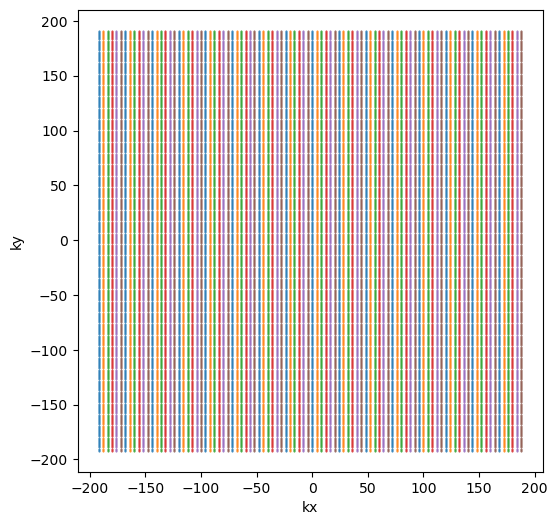

In [8]:
# vizualize sampling patterns
plt.figure(figsize=(6,6))
for i in range(ktraj.shape[0]):
    plt.scatter(ktraj[i,:,1].cpu(), ktraj[i,:,0].cpu(),s=0.2 )

plt.xlabel('kx')
plt.ylabel('ky')

## Do adjoint recon without accounting for motion

In [9]:
adj_moco_img = motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles=torch.zeros_like(gt_theta),dx = torch.zeros_like(gt_dx), dy = torch.zeros_like(gt_dy),img_shape=maps.shape,device=device)

tensor(0.0002, device='cuda:0', dtype=torch.float64)


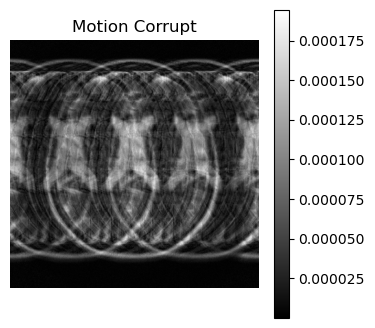

In [10]:
plt.figure(figsize=(4,4))
plt.title('Motion Corrupt')
plt.imshow(torch.flipud(abs(adj_moco_img.cpu())[0,0]),cmap='gray')
plt.colorbar()
plt.axis('off')

norm = torch.max(abs(adj_moco_img))
print(norm)

## Do CG based Recons

Note: accounting for motion in the Forward/Adjoint hurts the condition number so convergence is slower for the recon with correct motion estimates. If you're curious just calculate the condition number using power iteration

In [11]:
# Do recon with known motion states
rhs =  motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles= gt_theta,dx = gt_dx, dy = gt_dy,img_shape=maps.shape,device=device)
rhs_scaled = rhs/torch.max(abs(rhs))
known_motion_cg, iter= conjgrad_motion_nufft(x=rhs_scaled, b=rhs_scaled, ktraj=ktraj, maps=maps, thetas=gt_theta, dx=gt_dx, dy=gt_dy, max_iter=35
                                , l2lam=.001, eps=1e-4, verbose=False, complex=True, device=device)

In [12]:
# Do recon with unknown motion states
rhs =   motion_adjoint(ksp = y_meas,coords=ktraj, s_maps = maps, angles=torch.zeros_like(gt_theta),dx = torch.zeros_like(gt_dx), dy = torch.zeros_like(gt_dy),img_shape=maps.shape,device=device)
rhs_scaled = rhs/torch.max(abs(rhs))
unknown_motion_cg, iter= conjgrad_motion_nufft(x=rhs_scaled, b=rhs_scaled, ktraj=ktraj, maps=maps, thetas=torch.zeros_like(gt_theta), dx=torch.zeros_like(gt_dx), dy=torch.zeros_like(gt_dy), max_iter=35
                                , l2lam=.001, eps=1e-4, verbose=False, complex=True, device=device)

(-0.5, 383.5, 383.5, -0.5)

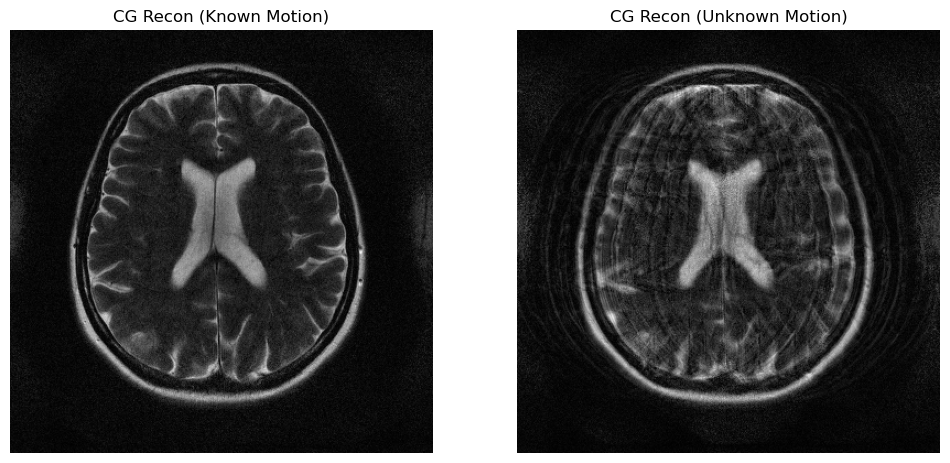

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('CG Recon (Known Motion)')
plt.imshow(torch.flipud(abs(known_motion_cg.cpu())[0,0]),cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('CG Recon (Unknown Motion)')
plt.imshow(torch.flipud(abs(unknown_motion_cg.cpu())[0,0]),cmap='gray')
plt.axis('off')

## Diffusion Motion Correction Recon

In [14]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import argparse
from utils import nrmse
from sampling_funcs import StackedRandomGenerator,ODE_motion_sampler
import pickle
import dnnlib
from torch_utils import distributed as dist
device = 'cuda'

In [15]:
norm_c = torch.max(abs(gt_img.cpu()))
ksp_norm = y_meas/norm_c
gt_img_norm = gt_img.cuda()/norm_c


In [17]:
# load network
net_save = '/csiNAS2/slow/brett/edm_outputs/00027-T2-uncond-ddpmpp-edm-gpus4-batch16-fp32-T2/network-snapshot-010000.pkl' # change to YOUR path
if dist.get_rank() != 0:
        torch.distributed.barrier()

# Load network.
dist.print0(f'Loading network from "{net_save}"...')
with dnnlib.util.open_url(net_save, verbose=(dist.get_rank() == 0)) as f:
    net = pickle.load(f)['ema'].to(device)

Loading network from "/csiNAS2/slow/brett/edm_outputs/00027-T2-uncond-ddpmpp-edm-gpus4-batch16-fp32-T2/network-snapshot-010000.pkl"...


In [18]:
seed = 0
rnd = StackedRandomGenerator(device, [seed])
latents = rnd.randn([1, 2, 384, 384], device=device)
class_labels = None
class_idx = None
if net.label_dim:
    class_labels = torch.eye(net.label_dim, device=device)[rnd.randint(net.label_dim, size=[batch_size], device=device)]
if class_idx is not None:
    class_labels[:, :] = 0
    class_labels[:, class_idx] = 1

In [19]:
img_lss = 1.0
mot_lss = 1.0
num_steps = 300
sigma_max = 5.0
S_noise = 0
motion_est = 1

In [20]:
image_recon, est_theta, est_dx, est_dy = ODE_motion_sampler(net=net, y=ksp_norm, maps=maps,traj=ktraj, 
                                        latents=latents, img_l_ss=img_lss,motion_l_ss=mot_lss, class_labels=class_labels, 
                                        randn_like=torch.randn_like, num_steps=num_steps, sigma_min=0.002, 
                                        sigma_max=sigma_max, rho=7, S_churn=420, S_min=0, S_max=float('inf'),
                                        S_noise= S_noise, motion_est = motion_est,
                                        gt_img=gt_img_norm, gt_theta=gt_theta, gt_dx=gt_dx, gt_dy=gt_dy, group_ETL=1)
cplx_recon = torch.view_as_complex(image_recon.permute(0,-2,-1,1).contiguous())[None] #shape: [1,1,H,W]

Step:0 , img NRMSE: 36.272, theta NRMSE: 1.000, dx NRMSE: 1.000, dy NRMSE: 1.000
Step:1 , img NRMSE: 35.696, theta NRMSE: 1.000, dx NRMSE: 1.000, dy NRMSE: 1.001
Step:2 , img NRMSE: 35.127, theta NRMSE: 1.001, dx NRMSE: 0.999, dy NRMSE: 1.000
Step:3 , img NRMSE: 34.567, theta NRMSE: 1.000, dx NRMSE: 0.999, dy NRMSE: 1.000
Step:4 , img NRMSE: 34.014, theta NRMSE: 1.000, dx NRMSE: 0.998, dy NRMSE: 1.000
Step:5 , img NRMSE: 33.468, theta NRMSE: 1.000, dx NRMSE: 0.998, dy NRMSE: 0.999
Step:6 , img NRMSE: 32.930, theta NRMSE: 1.000, dx NRMSE: 0.997, dy NRMSE: 0.998
Step:7 , img NRMSE: 32.399, theta NRMSE: 1.000, dx NRMSE: 0.997, dy NRMSE: 0.998
Step:8 , img NRMSE: 31.876, theta NRMSE: 1.000, dx NRMSE: 0.997, dy NRMSE: 0.997
Step:9 , img NRMSE: 31.359, theta NRMSE: 1.000, dx NRMSE: 0.996, dy NRMSE: 0.996
Step:10 , img NRMSE: 30.850, theta NRMSE: 1.000, dx NRMSE: 0.996, dy NRMSE: 0.995
Step:11 , img NRMSE: 30.348, theta NRMSE: 1.001, dx NRMSE: 0.996, dy NRMSE: 0.993
Step:12 , img NRMSE: 29.85

(-0.5, 383.5, 383.5, -0.5)

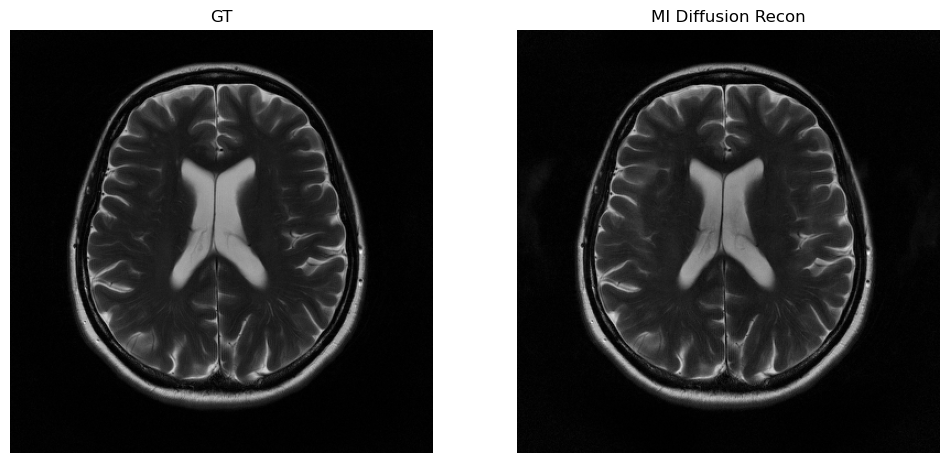

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('GT')
plt.imshow(torch.flipud(abs(gt_img_norm[0,0].cpu())), cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('MI Diffusion Recon')
plt.imshow(torch.flipud(abs(cplx_recon[0,0].cpu())), cmap = 'gray')
plt.axis('off')

Text(0.5, 0, 'TR')

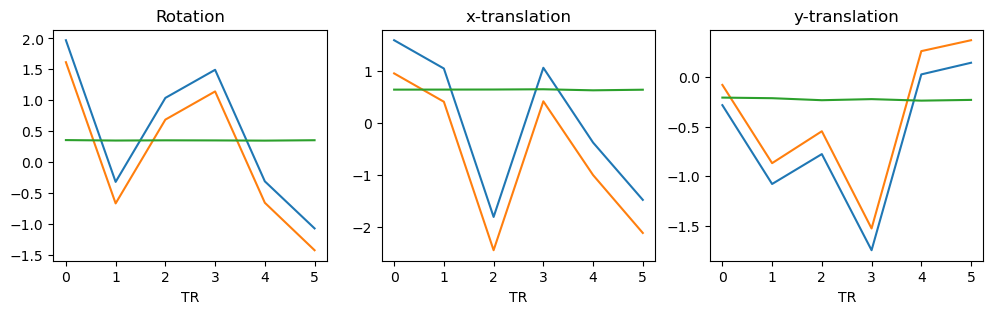

In [22]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title('Rotation')
plt.plot(gt_theta.cpu(),label='gt')
plt.plot(est_theta.detach().cpu(),label='est')
plt.plot(gt_theta.cpu()-est_theta.detach().cpu(),label='error')
plt.xlabel('TR')
plt.subplot(1,3,2)
plt.title('x-translation')
plt.plot(gt_dx.cpu(),label='gt')
plt.plot(est_dx.detach().cpu(),label='est')
plt.plot(gt_dx.cpu()-est_dx.detach().cpu(),label='error')
plt.xlabel('TR')
plt.subplot(1,3,3)
plt.title('y-translation')
plt.plot(gt_dy.cpu(),label='gt')
plt.plot(est_dy.detach().cpu(),label='est')
plt.plot(gt_dy.cpu()-est_dy.detach().cpu(),label='error')
plt.xlabel('TR')